In [73]:
#install required packages
!pip install umap-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

This dataset was located on Kaggle and was created by the user deepu1109. I provides several measurements of 24 stars and assigns each into 1 or 7 categories.

In [74]:
#read in the dataframe
stars=pd.read_csv("https://www.dropbox.com/scl/fi/j9s4mfsupvyusxbt6m7bs/stars.csv?rlkey=jw8sc3q69uuy42yovg5pwcxii&st=slsy3c42&dl=1")

In [75]:
stars.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color,Spectral Class
0,3068,0.002400,0.1700,16.12,0,Red,M
1,3042,0.000500,0.1542,16.60,0,Red,M
2,2600,0.000300,0.1020,18.70,0,Red,M
3,2800,0.000200,0.1600,16.65,0,Red,M
4,1939,0.000138,0.1030,20.06,0,Red,M


Spectral Class is the categorical variable. We can see below that it has 7 unique values. Ideally then we would be able to detect 7 clusters.

In [76]:
#view the 7 categories and their sample counts
stars["Spectral Class"].value_counts()

,count
Spectral Class,
M,111
B,46
O,40
A,19
F,17
K,6
G,1


In [77]:
#we have one categorical variable that we need to make numeric
stars=pd.get_dummies(stars,columns=["Star color"], drop_first=True, dtype=int)

stars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Temperature (K)                240 non-null    int64  
 1   Luminosity(L/Lo)               240 non-null    float64
 2   Radius(R/Ro)                   240 non-null    float64
 3   Absolute magnitude(Mv)         240 non-null    float64
 4   Star type                      240 non-null    int64  
 5   Spectral Class                 240 non-null    object 
 6   Star color_Blue                240 non-null    int64  
 7   Star color_Blue White          240 non-null    int64  
 8   Star color_Blue white          240 non-null    int64  
 9   Star color_Blue white          240 non-null    int64  
 10  Star color_Blue-White          240 non-null    int64  
 11  Star color_Blue-white          240 non-null    int64  
 12  Star color_Orange              240 non-null    int

We now have 240 observations across 22 features with one target variable containing 7 classes. We must note that the classes are very inbalanced.

In [78]:
#set up the features and target
X=stars.drop(columns=["Spectral Class"])
y=stars["Spectral Class"]

#as oberserved above, the features are completely different scales, in order to support dimensionality reduction
#and clustering we will standardize them
scaler=StandardScaler()
X_std=scaler.fit_transform(X)

print(X_std.shape, y.shape)

(240, 23) (240,)


For dimensionality reduction, we will go with T-SNE and UMAP. They are powerful modern approachs which will not require linearty.

In [79]:
tsne = TSNE(n_components=2, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(X_std)

umap_results = umap.UMAP(n_neighbors=5, min_dist=0.3, metric='correlation').fit_transform(X_std)

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [80]:
#map the spectral categories to colors usable by matplotlib
color_map = {
    'M': 'r',
    'B': 'b',
    'A': 'g',
    'F': 'c',
    'O': 'm',
    'K': 'y',
    'G': 'k'
}

First we will look at the T-SNE results

In [81]:
plt.figure(figsize=(8,4))
for i in range(tsne_results.shape[0]):
    color = color_map[y.iloc[i]]
    plt.text(tsne_results[i, 0], tsne_results[i, 1], str(y.iloc[i]),
             color=color,
             fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

We can clearly see different groupings but it must be noted that the clusters for even the same classifications are well spread out. It may be that the features for this dataset do not describe the problem space well enough.

Now for the UMAP visual.

In [82]:
plt.figure(figsize=(8,4))
for i in range(umap_results.shape[0]):
    color = color_map[y.iloc[i]]
    plt.text(umap_results[i, 0], umap_results[i, 1], str(y.iloc[i]),
             color=color,
             fontdict={'weight': 'bold', 'size': 50})

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

This ooks only slightly better than T-SNE in that we can see the global distribution a littl emore aligned to what we might actually expect - e.g. category M clusters anre somewhat closer together here.

We can view the UMAP results without the benefit of ground truth categories below.

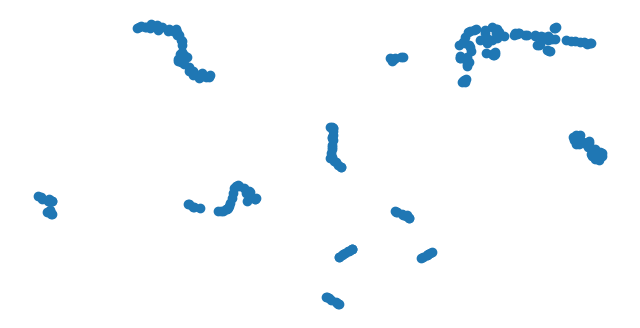

In [83]:
plt.figure(figsize=(8,4))
plt.scatter(umap_results[:,0],umap_results[:,1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [84]:
#import required cluster packages
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

Next we will try a couple of clustering algorithms and compare them using their ARI and Silhouette scores. I will be using Hierarchical and DBSCAN approaches. K-Means is not likely to do well here given then non-spherical and spread out nature of the clusters.

We will take advantage of the fact that we know that we have 7 categories in the set-up of these classfiiers.

In [85]:
#create heirarchical clusters
agg_cluster = AgglomerativeClustering(linkage="ward", n_clusters=7)
clusters = agg_cluster.fit_predict(X_std)

In [86]:
print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.5304213463432876
Silhouette score: 0.46613774758504756


The ARI score of .53 is not too bad given that we have 7 true clusters. It is at least better then random. The Silhoutte score of .46 also is not terrible, given that is ranges from -1 to 1.

For DBSCAN, we will first try to get an indication of a good number to set for min_samples.

In [87]:
min_list=range(1,20)

#try different min_samples values
for i in min_list:
  dbs_cluster = DBSCAN(eps=1, min_samples=i, metric="euclidean")
  clusters = dbs_cluster.fit_predict(X_std)
  print(f"For a min_samples of {i} we get {len(np.unique(clusters))} clusters")

For a min_samples of 1 we get 36 clusters
For a min_samples of 2 we get 19 clusters
For a min_samples of 3 we get 14 clusters
For a min_samples of 4 we get 10 clusters
For a min_samples of 5 we get 10 clusters
For a min_samples of 6 we get 9 clusters
For a min_samples of 7 we get 9 clusters
For a min_samples of 8 we get 9 clusters
For a min_samples of 9 we get 8 clusters
For a min_samples of 10 we get 7 clusters
For a min_samples of 11 we get 6 clusters
For a min_samples of 12 we get 6 clusters
For a min_samples of 13 we get 5 clusters
For a min_samples of 14 we get 5 clusters
For a min_samples of 15 we get 5 clusters
For a min_samples of 16 we get 5 clusters
For a min_samples of 17 we get 5 clusters
For a min_samples of 18 we get 3 clusters
For a min_samples of 19 we get 3 clusters


We'll go with min_samples=10 since that produced the same number of actual categories in our data.

In [88]:
#create dbscan clusters
dbs_cluster = DBSCAN(eps=1, min_samples=10, metric="euclidean")
clusters = dbs_cluster.fit_predict(X_std)

In [89]:
print(f"ARI score: {metrics.adjusted_rand_score(y, clusters)}")
print(f"Silhouette score: {metrics.silhouette_score(X_std, clusters, metric='euclidean')}")

ARI score: 0.46363290745498326
Silhouette score: 0.44931054955319555


Both scores here are slightly worse than that of the heirarchical approach.